# Rain over Africa (RoA)

This notebook loads and visualises 15-minute Rain over Africa (RoA) rainfall rate fields over Africa.  
The RoA variable `posterior_mean` represents the posterior mean of the predicted rainfall-rate CDF (**mm h⁻¹**) on a regular lat–lon grid.

RoA files follow the naming convention `MSG3YYYYMMDD-SHHMM-EHHMM.nc`, where the filename encodes the start and end times of each 15-minute retrieval window.


In [1]:
import numpy as np 
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import cartopy.crs as ccrs                              
import cartopy.feature as cfeature                   
import cartopy.io.shapereader as shpreader

import warnings
warnings.filterwarnings("ignore")

--------------------------------------------------------------------------
detected:

  Local host:            host839
  Device name:           mlx5_bond_0
  Device vendor ID:      0x02c9
  Device vendor part ID: 4127

Default device parameters will be used, which may result in lower
performance.  You can edit any of the files specified by the
btl_openib_device_param_files MCA parameter to set values for your
device.

NOTE: You can turn off this warning by setting the MCA parameter
      btl_openib_warn_no_device_params_found to 0.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           host839
  Local device:         mlx5_bond_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
-------

In [2]:
path_ROA = "/gws/ssde/j25b/swift/RoA"

year = "2024"
month = "07"
day = "15"
hour = "12"
minute = "00"

t0 = datetime(
    int(year), int(month), int(day),
    int(hour), int(minute)
)

t1 = t0 + timedelta(minutes=15)

file_path = (
    f"{path_ROA}/{year}/{month}/"
    f"MSG3{t0:%Y%m%d}"
    f"-S{t0:%H%M}"
    f"-E{t1:%H%M}.nc"
)


# File reading

In [3]:
ds = Dataset(file_path)

lat = ds.variables["latitude"][:]     # shape (Ny,)
lon = ds.variables["longitude"][:]    # shape (Nx,)

roa = ds.variables["posterior_mean"][:]  # shape (Ny, Nx)

In [4]:
print(ds.variables["posterior_mean"])

<class 'netCDF4._netCDF4.Variable'>
float64 posterior_mean(latitude, longitude)
    _FillValue: nan
    info: Posterior mean of predicted CDF (mm/hr).
unlimited dimensions: 
current shape = (2962, 2777)
filling off


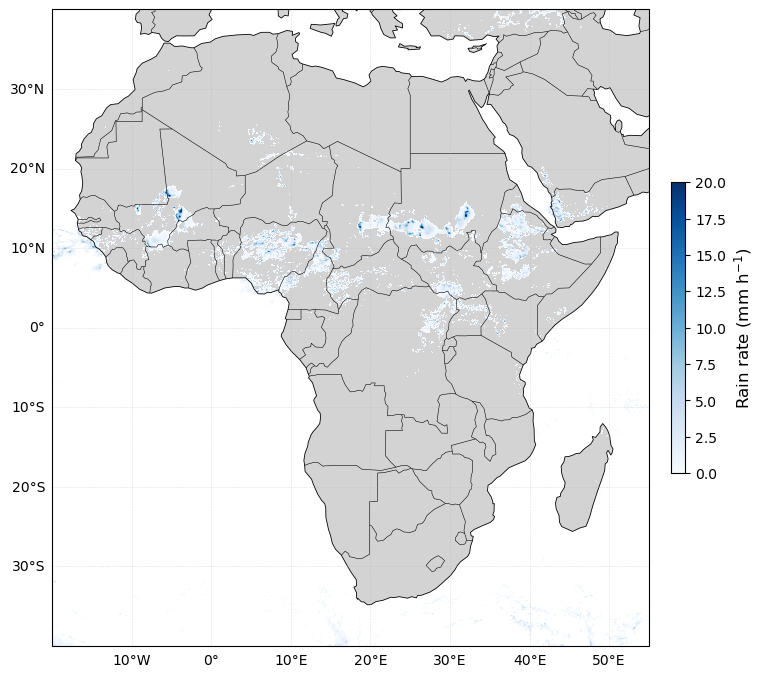

In [5]:
# Create 2D coordinate grids from 1D lat/lon
lon2d, lat2d = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

extent = (
    lon.min(),
    lon.max(),
    lat.min(),
    lat.max(),
)

ax.set_extent(extent, crs=ccrs.PlateCarree())

# Base map features (quiet background)
ax.add_feature(cfeature.LAND, facecolor="lightgrey", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, zorder=2)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, zorder=2)

# Gridlines (subtle)
gl = ax.gridlines(
    draw_labels=True,
    linestyle="--",
    linewidth=0.4,
    alpha=0.4
)
gl.top_labels = False
gl.right_labels = False

# Mask very weak rain to improve contrast
roa_plot = np.ma.masked_less(roa, 0.1)

im = ax.pcolormesh(
    lon2d,
    lat2d,
    roa_plot,
    transform=ccrs.PlateCarree(),
    cmap="Blues",
    vmin=0.0,
    vmax=20.0,
    zorder=1,
)

cbar = plt.colorbar(im, ax=ax, pad=0.03, shrink=0.3)
cbar.set_label("Rain rate (mm h$^{-1}$)", fontsize=12)
plt.tight_layout()
plt.show()
